In [1]:
import pandas as pd

In [2]:
df_train = pd.read_csv("datalatihfix.csv", sep=",")
df_test = pd.read_csv("dataujifix.csv", sep=",")
X_train2 = df_train.drop(['price'], axis=1, inplace=False)
y_train = df_train['price']
X_test2 = df_test.drop(['id'], axis=1, inplace=False)

## XGBoost Regression

In [3]:
import numpy as np
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state = 0)
xgb.fit(X_train2, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=0, ...)

In [4]:
from xgboost import XGBRegressor
from sklearn.model_selection import RandomizedSearchCV
import time

# A parameter grid for XGBoost
params = {
    'n_estimators':[500],
    'min_child_weight':[4,5], 
    'gamma':[i/10.0 for i in range(3,6)],  
    'subsample':[i/10.0 for i in range(6,11)],
    'colsample_bytree':[i/10.0 for i in range(6,11)], 
    'max_depth': [2,3,4,6,7],
    'objective': ['reg:linear'],
    'booster': ['gbtree', 'gblinear'],
    'eval_metric': ['rmse'],
    'eta': [i/10.0 for i in range(3,6)],
}

reg = XGBRegressor(nthread=-1)

# run randomized search
n_iter_search = 100
random_search = RandomizedSearchCV(reg, param_distributions=params,
                                   n_iter=n_iter_search, cv=5, scoring='r2')

start = time.time()
random_search.fit(X_train2, y_train)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))

[11:06:21] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:06:59] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:07:38] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:08:03] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[11:08:29] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-10.9-x86_64-cpython-38/xgboost/src/objective/regress

In [5]:
random_search.best_estimator_

XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eta=0.3, eval_metric='rmse',
             feature_types=None, gamma=0.3, gpu_id=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
             max_leaves=None, min_child_weight=4, missing=nan,
             monotone_constraints=None, n_estimators=500, n_jobs=None,
             nthread=-1, num_parallel_tree=None, ...)

In [6]:
xgb_R2_2 = round(random_search.score(X_train2, y_train)*100, 3)
print('R squared training set', xgb_R2_2)

R squared training set 48.265


In [7]:
xgb_R2 = round(xgb.score(X_train2, y_train)*100, 3)
print('R squared training set', xgb_R2)

R squared training set 60.669


In [8]:
from sklearn.metrics import mean_squared_error
from math import sqrt

pred_train_xgb = random_search.predict(X_train2)
mse_train_xgb = mean_squared_error(y_train, pred_train_xgb)
print('RMSE training set', round(sqrt(mse_train_xgb), 2))

pred = random_search.predict(X_test2)
xgb_pred = pd.DataFrame().assign(
    id = df_test['id'],
    price = pred
)
xgb_pred


RMSE training set 120.93


,id,price
0,17423675,318.261963
1,6226658,135.744370
2,3563677,197.880890
3,17615783,147.501205
4,2479317,205.598618
...,...,...
22227,14838304,172.857620
22228,7331958,108.441055
22229,7935934,158.671921
22230,808802,85.273033


In [9]:
xgb_pred = xgb_pred.sort_values('id')

In [10]:
xgb_pred.to_csv("xgb_pred3.csv", sep=",", index=False)

## RF Regression

In [11]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor()

rf.fit(X_train2, y_train)

RandomForestRegressor()

In [12]:
# Define the Estimator and the Parameter Ranges
dt = RandomForestRegressor()
number_of_iterations = 20
max_leaf_nodes = [5, 10, 20, 40, 50, 75, 100]
min_samples_split = [5, 10, 20, 40, 50, 75, 100]
max_depth = [5,10,20, 40, 50, 75, 100]
# max_features = [5,]
n_estimators = [10, 50, 100, 150, 200, 250, 500]

# Define the param distribution dictionary
param_distributions = dict(max_leaf_nodes=max_leaf_nodes, 
                           min_samples_split=min_samples_split, 
                           max_depth=max_depth,
                        #    max_features=max_features,
                           n_estimators=n_estimators)

# Build the gridsearch
grid = RandomizedSearchCV(estimator=dt, 
                          param_distributions=param_distributions, 
                          n_iter=number_of_iterations, 
                          cv = 5)

grid_results = grid.fit(X_train2, y_train)

# Summarize the results in a readable format
print("Best params: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_df = pd.DataFrame(grid_results.cv_results_)

Best params: [0.42234971 0.41568902 0.43378116 0.38268983 0.42668095 0.43070229
 0.43273402 0.43169586 0.42735026 0.4318956  0.42456156 0.41507463
 0.43276355 0.38041017 0.38034952 0.42348977 0.41831291 0.4303071
 0.42799906 0.4301632 ], using {'n_estimators': 250, 'min_samples_split': 40, 'max_leaf_nodes': 50, 'max_depth': 75}


In [13]:
grid_results.best_estimator_

RandomForestRegressor(max_depth=75, max_leaf_nodes=50, min_samples_split=40,
                      n_estimators=250)

In [14]:
rf_R2 = round(grid_results.score(X_train2, y_train)*100, 3)
print('R squared training set', rf_R2)

R squared training set 46.976


In [15]:
pred_train_rf = grid_results.predict(X_train2)
mse_train_rf = mean_squared_error(y_train, pred_train_rf)
print('RMSE training set', round(sqrt(mse_train_rf), 2))

pred = grid_results.predict(X_test2)
rf_pred = pd.DataFrame().assign(
    id = df_test['id'],
    price = pred
)
rf_pred

RMSE training set 122.43


,id,price
0,17423675,271.469817
1,6226658,88.260282
2,3563677,153.690183
3,17615783,88.260282
4,2479317,153.690183
...,...,...
22227,14838304,153.690183
22228,7331958,88.260282
22229,7935934,89.832461
22230,808802,88.260282


In [16]:
rf_pred = rf_pred.sort_values('id')

In [17]:
rf_pred.to_csv("rf_pred3.csv", sep=",", index=False)

## Huber Regression

In [18]:
from sklearn.linear_model import HuberRegressor

hb = HuberRegressor()

hb.fit(X_train2, y_train)

HuberRegressor()

In [19]:
# Define Parameters for Huber Regression
dt = HuberRegressor()
epsilon = np.arange(0, 5, 0.5)
max_iter = [20, 50, 100, 150, 200, 500]
alpha = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.5, 2, 5, 10]
warm_start = [True, False]
number_of_iterations = 20
grid = RandomizedSearchCV(estimator=dt, 
                          param_distributions= dict(
                              epsilon=epsilon,
                              max_iter = max_iter,
                              alpha = alpha,
                              warm_start = warm_start
                              ), 
                          n_iter=number_of_iterations,
                          cv = 5)
grid_results = grid.fit(X_train2, y_train)
print("Best params: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_df = pd.DataFrame(grid_results.cv_results_)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:335: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:335: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/linear_model/_huber.py:335: ConvergenceWarning: lb

Best params: [ 0.25848966  0.31267811  0.26690562  0.25746254 -0.18152069  0.30335745
  0.33948463         nan -0.08438188         nan         nan  0.30581283
  0.26300831 -0.29481676         nan  0.25844807 -0.08436538  0.25844807
  0.31498081  0.3024018 ], using {'warm_start': False, 'max_iter': 100, 'epsilon': 4.5, 'alpha': 5}


In [20]:
grid_results.best_estimator_

HuberRegressor(alpha=5, epsilon=4.5)

In [21]:
hb_R2 = round(grid_results.score(X_train2, y_train)*100, 3)
print('R squared training set', hb_R2)

R squared training set 31.298


In [22]:
pred_train_hb = grid_results.predict(X_train2)
mse_train_hb = mean_squared_error(y_train, pred_train_hb)
print('RMSE training set', round(sqrt(mse_train_hb), 2))

pred = grid_results.predict(X_test2)
hb_pred = pd.DataFrame().assign(
    id = df_test['id'],
    price = pred
)
hb_pred

RMSE training set 139.36


,id,price
0,17423675,217.245633
1,6226658,120.390370
2,3563677,178.556506
3,17615783,107.937903
4,2479317,185.447703
...,...,...
22227,14838304,179.935270
22228,7331958,100.200579
22229,7935934,420.265555
22230,808802,105.460579


In [23]:
hb_pred = hb_pred.sort_values('id')

In [24]:
hb_pred.to_csv("hb_pred2.csv", sep=",", index=False)

## Bayesian Ridge Regression

In [25]:
from sklearn.linear_model import BayesianRidge

br = BayesianRidge()

br.fit(X_train2, y_train)

BayesianRidge()

In [26]:
dt = BayesianRidge()
import numpy as np
n_iter = np.arange(100, 1000, 50)
alpha_1 = np.arange(0, 1, 0.001)
alpha_2 = np.arange(0, 1, 0.001)
lambda_1 = np.arange(0, 3, 0.005)
lambda_2 = np.arange(0, 3, 0.005)
fit_intercept = [False, True]
number_of_iterations = 20
grid = RandomizedSearchCV(estimator=dt, 
                          param_distributions= dict(
                              n_iter = n_iter,
                              alpha_1 = alpha_1,
                              alpha_2 = alpha_2,
                              lambda_1 = lambda_1,
                              lambda_2 = lambda_2,
                              fit_intercept = fit_intercept,
                              ), 
                          n_iter=number_of_iterations,
                          cv = 5)
grid_results = grid.fit(X_train2, y_train)
print("Best params: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_df = pd.DataFrame(grid_results.cv_results_)

Best params: [0.39526994 0.39526031 0.39527699 0.39527692 0.39527562 0.3952865
 0.39527674 0.39527792 0.39527682 0.3952785  0.3952833  0.39526686
 0.39527983 0.39527568 0.39528013 0.39526623 0.39526563 0.3952799
 0.39527599 0.39526553], using {'n_iter': 350, 'lambda_2': 2.605, 'lambda_1': 2.88, 'fit_intercept': True, 'alpha_2': 0.199, 'alpha_1': 0.554}


In [27]:
grid_results.best_estimator_

BayesianRidge(alpha_1=0.554, alpha_2=0.199, lambda_1=2.88, lambda_2=2.605,
              n_iter=350)

In [28]:
br_R2 = round(grid_results.score(X_train2, y_train)*100, 3)
print('R squared training set', br_R2)

R squared training set 39.622


In [29]:
pred_train_br = grid_results.predict(X_train2)
mse_train_br = mean_squared_error(y_train, pred_train_br)
print('RMSE training set', round(sqrt(mse_train_br), 2))

pred = grid_results.predict(X_test2)
br_pred = pd.DataFrame().assign(
    id = df_test['id'],
    price = pred
)
br_pred

RMSE training set 130.64


,id,price
0,17423675,289.558612
1,6226658,133.709578
2,3563677,168.043850
3,17615783,59.501725
4,2479317,177.907438
...,...,...
22227,14838304,188.289976
22228,7331958,114.723633
22229,7935934,254.418594
22230,808802,59.763657


In [30]:
br_pred = br_pred.sort_values('id')

In [31]:
br_pred.to_csv("br_pred2.csv", sep=",", index=False)

## ARD Regression

In [32]:
from sklearn.linear_model import ARDRegression

ard = ARDRegression()

ard.fit(X_train2, y_train)

ARDRegression()

In [33]:
dt = ARDRegression()
alpha_1 = np.arange(0, 5, 0.005)
alpha_2 = np.arange(0, 5, 0.005)
lambda_1 = np.arange(0, 5, 0.005)
lambda_2 = np.arange(0, 5, 0.005)
number_of_iterations = 300
grid = RandomizedSearchCV(estimator=dt, 
                          param_distributions= dict(
                              alpha_1=alpha_1,
                              alpha_2 = alpha_2,
                              lambda_1 = lambda_1,
                              lambda_2 = lambda_2
                              ), 
                          n_iter=number_of_iterations,
                          cv = 5)
grid_results = grid.fit(X_train2, y_train)
print("Best params: {0}, using {1}".format(grid_results.cv_results_['mean_test_score'], grid_results.best_params_))
results_df = pd.DataFrame(grid_results.cv_results_)

Best params: [0.39486119 0.39479178 0.39471627 0.39498145 0.39380778 0.39494456
 0.39495644 0.39475017 0.39491969 0.39481446 0.39494536 0.39500178
 0.39492794 0.39505429 0.39503186 0.39523882 0.39483479 0.39474265
 0.39499525 0.39505335 0.39489476 0.39473147 0.3948434  0.3947714
 0.39488388 0.3948608  0.39504865 0.39487758 0.39475912 0.39478249
 0.39504453 0.39477851 0.39501082 0.3949488  0.39490174 0.39484652
 0.39505889 0.39487549 0.39488832 0.39483909 0.395056   0.39495705
 0.39501949 0.39507542 0.39469508 0.39524668 0.39496115 0.39506514
 0.39496623 0.39487435 0.39481957 0.39506341 0.39506317 0.3947401
 0.39470674 0.39504954 0.39497029 0.39501878 0.39505551 0.39488096
 0.39478775 0.39492625 0.39479026 0.3950321  0.39470345 0.3949813
 0.39503241 0.39497711 0.39499461 0.39477213 0.39483536 0.39502645
 0.39495709 0.39505288 0.3949747  0.39474135 0.3949226  0.3950719
 0.39497808 0.39501783 0.39494682 0.39489489 0.39491876 0.39480206
 0.39498187 0.39498049 0.39503969 0.39500716 0.394851

In [34]:
grid.best_estimator_

ARDRegression(alpha_1=4.86, alpha_2=1.8800000000000001, lambda_1=0.055,
              lambda_2=4.715)

In [35]:
ard_R2 = round(grid_results.score(X_train2, y_train)*100, 3)
print('R squared training set', ard_R2)

R squared training set 39.634


In [36]:
pred_train_ard = grid_results.predict(X_train2)
mse_train_ard = mean_squared_error(y_train, pred_train_ard)
print('RMSE training set', round(sqrt(mse_train_ard), 2))

pred = grid_results.predict(X_test2)
ard_pred = pd.DataFrame().assign(
    id = df_test['id'],
    price = pred
)
ard_pred

RMSE training set 130.63


,id,price
0,17423675,289.606220
1,6226658,133.793597
2,3563677,168.198213
3,17615783,59.538332
4,2479317,177.881982
...,...,...
22227,14838304,188.204514
22228,7331958,114.520152
22229,7935934,254.364328
22230,808802,59.800350


In [37]:
ard_pred = ard_pred.sort_values('id')

In [38]:
ard_pred.to_csv("ard_pred2.csv", sep=",", index=False)

## Result

In [39]:
xgb_rmse = round(sqrt(mse_train_xgb), 2)
rf_rmse = round(sqrt(mse_train_rf), 2)
hb_rmse = round(sqrt(mse_train_hb), 2)
br_rmse = round(sqrt(mse_train_br), 2)
ard_rmse = round(sqrt(mse_train_ard), 2)

In [41]:
models = ['XGBoost', 'RF', 'Huber', 'Bayesian Ridge', 'ARD']
rmse = [xgb_rmse, rf_rmse, hb_rmse, br_rmse, ard_rmse]
rsqs = [xgb_R2, rf_R2, hb_R2, br_R2, ard_R2]
result = pd.DataFrame().assign(
    model = models,
    rmse = rmse,
    r_square = rsqs
)

In [42]:
result

,model,rmse,r_square
0,XGBoost,120.93,60.669
1,RF,122.43,46.976
2,Huber,139.36,31.298
3,Bayesian Ridge,130.64,39.622
4,ARD,130.63,39.634


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


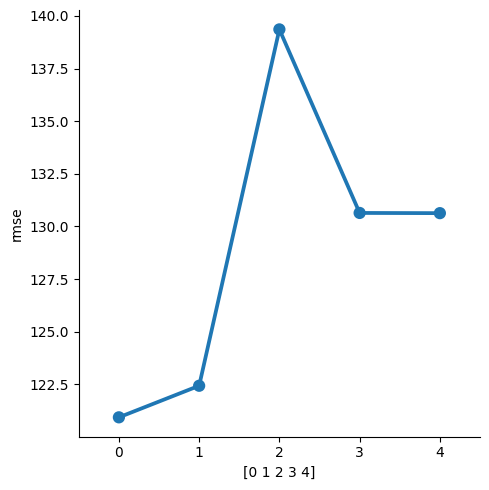

In [43]:
import seaborn as sns
sns.catplot(data=result, x=np.arange(0, len(result)), y="rmse", kind="point")